<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v8: Productionising Activity capturing and visualisation
This notebook carries on from v5 with work to productionise the capture and display of unit activation information.

It uses a simple callback, and starts simple with its data collection.

In [55]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
!cd repo && git checkout ea80c40
#!cd repo && git pull

import sys
sys.path.append('repo')

import toolkit
from importlib import reload
reload(toolkit)

HEAD is now at 3a07057 Merge remote-tracking branch 'refs/remotes/origin/main'
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 694 bytes | 231.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   3a07057..4b6f3c2  main       -> origin/main
Updating 3a07057..4b6f3c2
Fast-forward
 toolkit.py | 49 ++++++++++++++++++++-----------------------------
 1 file changed, 20 insertions(+), 29 deletions(-)


<module 'toolkit' from '/content/repo/toolkit.py'>

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic setup

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


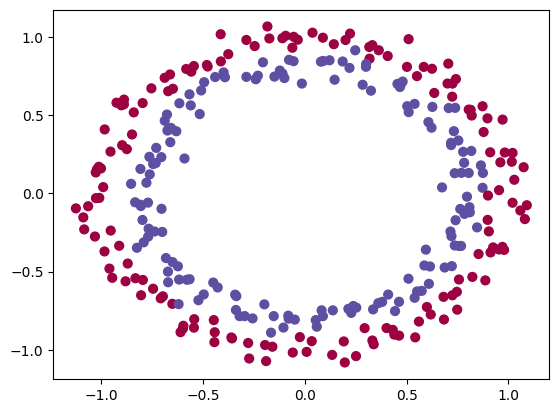

In [3]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

## Unit Activation Rates
Firstly, we're interested not in the floating point range of unit outputs, but rather whether the units are "active" or not. Determined simply by whether the ReLU unit passes the value through, or drops the output and returns `0.0`. For other other activation functions a unit is always considered "active", and that's fine.

In this first cut there's two measures of unit activity that we'll use:
* fraction of "dead units"
  * The percentage of units that are never active - always produce `0.0` as output.
  * This is across all items in the entire training dataset (eg: across all batches).
  * This is also across all spatial coordinates of any CNNs.
* mean rate of activation
  * The mean percentage of units that are active at any given moment in time - having a non-zero output.
  * This will be aggregated down to the channels dimension, and then averaged again (see below).

In both cases, we are primarily interested in the effect on gradient propagation. This means that we treat the tensor axis with a particular interpretation:
* `(B, ..spatial dims.., C)` - batch, spatial, channels
* eg: Simple dense network: `(B, C)`
* eg: 2D CNN: `(B, H, W, C)`
* eg: 3D CNN: `(B, H, W, D, C)` - batch, height, width, depth, channels
* eg: Dense against CNN input - `(B, ..spatial.., C)`
* Aggregated across batch and spatial dims
* Each channel treated separately

Notice that there's precedent for this way of handling the axis in how TF Dense layers handle multi-dimensional input -- they act as a CNN with a 1x1 filter, operating as a dense network across the last axis only, and otherwise sharing weights and repeating against all other axis. In the Dense docs, it refers to treating all those earlier axis as the "batch dimensions".

In practice, as we'll be interested initially only in getting stats across the entire model and for individual layers, processing will thus go as follows:
1. Aggregate "dead units" and "mean activation" across batch and spatial dims, producing a single vector across the channels dimension only.
2. Aggregate across all batches in dataset, still producing a single vector across the channels dimension only.
3. Finally, turn into a scalar as the rates/means across the channels.

Epoch   100 - 104.50ms/epoch: loss: 0.2526  
Epoch   200 - 83.79ms/epoch: loss: 0.0801  
Epoch   300 - 68.83ms/epoch: loss: 0.0972  
Epoch   400 - 87.39ms/epoch: loss: 0.0053  
Epoch   500 - 81.15ms/epoch: loss: 0.0068  
Epoch   600 - 74.35ms/epoch: loss: 0.0015  
Epoch   700 - 92.20ms/epoch: loss: 0.0063  
Epoch   800 - 77.74ms/epoch: loss: 0.0001  
Epoch   900 - 83.47ms/epoch: loss: 0.0000  
Epoch  1000 - 130.49ms/epoch: loss: 0.0000  
Total training time: 88.87 secs


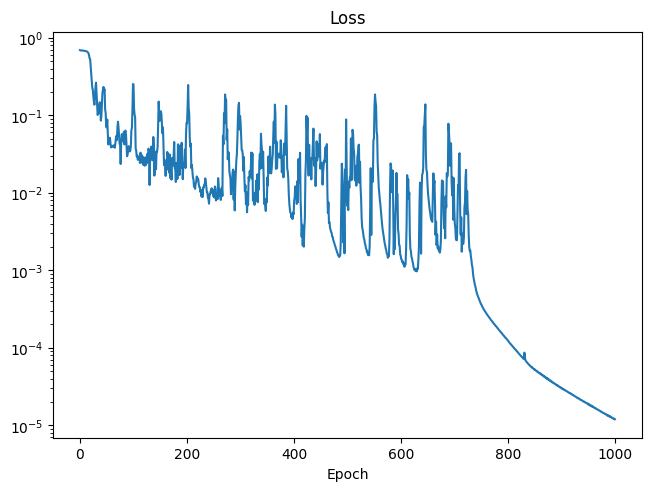

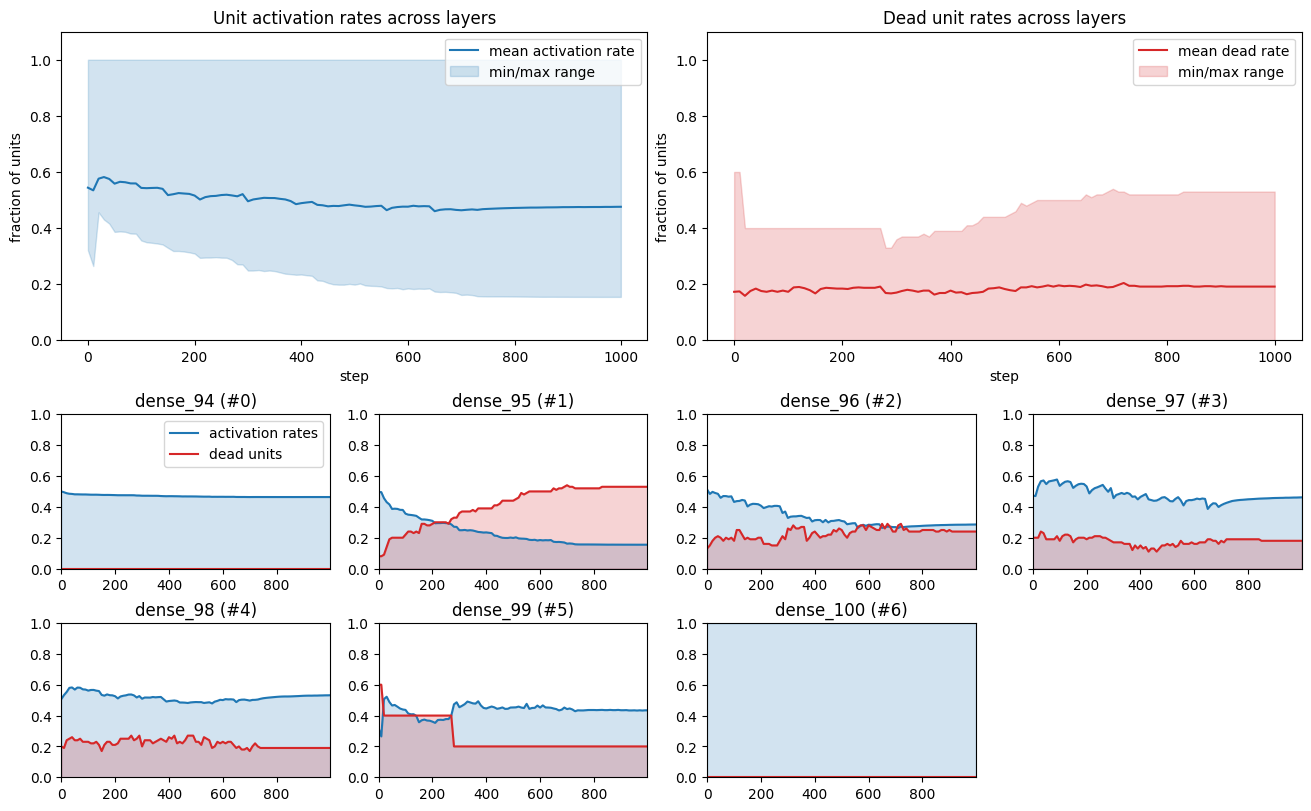

In [57]:
tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
activity = toolkit.ActivityRateCallback(dataset, interval=10)
history = model.fit(dataset.batch(32), epochs=1000, verbose=0, callbacks=[toolkit.LessVerboseProgressLogger(), activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

activity.plot_summary()

In [295]:
model.summary()

Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_369 (Dense)                    │ (None, 100)                 │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_370 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_371 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_372 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_373 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_374 (Dense)                    │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_375 (Dense)                    │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,635 (482.95 KB)

 Trainable params: 41,211 (160.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 82,424 (321.97 KB)

## MNIST Model
Now let's try against the MNIST database and model.

In [4]:
def mnist_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

train_X, train_Y = mnist_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
train_X: (60000, 28, 28), train_Y: (60000,)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8322 - loss: 0.5460
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9602 - loss: 0.1390
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9724 - loss: 0.0918
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9800 - loss: 0.0667
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9848 - loss: 0.0501
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9878 - loss: 0.0402
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9893 - loss: 0.0335
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9913 - loss: 0.0259
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9918 - loss: 0.0222
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.9926 - loss: 0.0223
Total training time: 201.55 secs


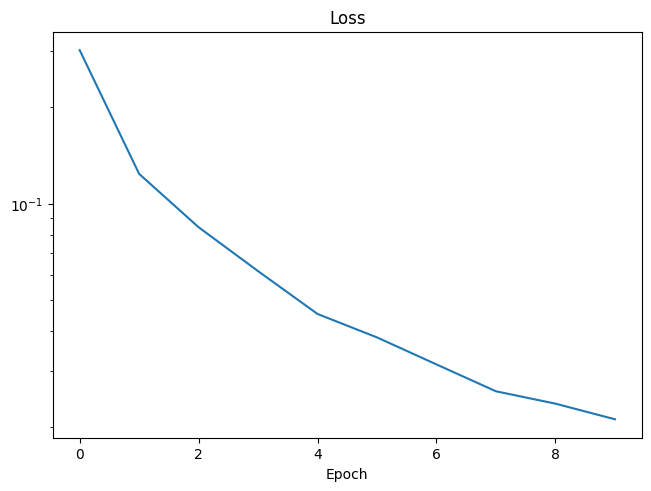

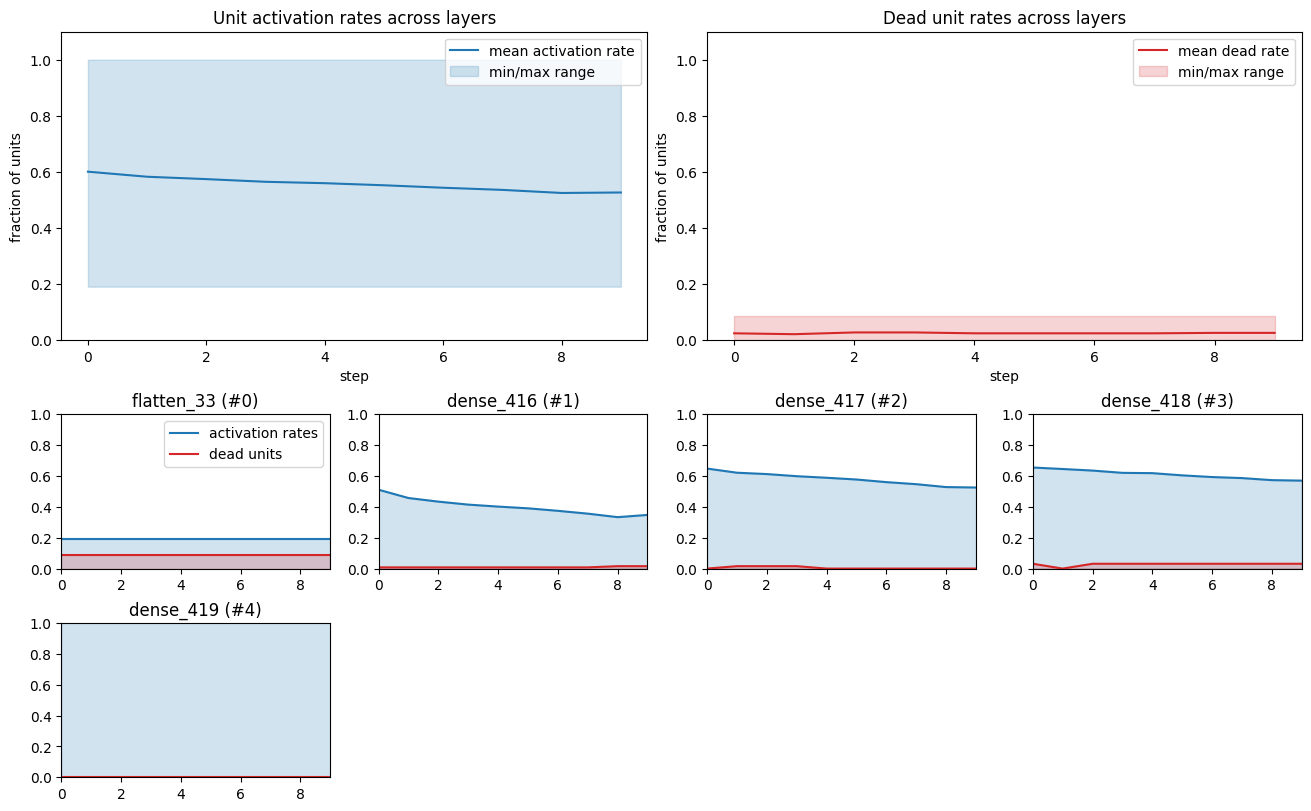

In [321]:
start = tf.timestamp()
model = mnist_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
activity = toolkit.ActivityRateCallback(dataset)
history = model.fit(dataset, epochs=10, callbacks=[activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

for l, stats in enumerate(activity.layer_stats):
  if np.sum(stats['activation_rate'] > 1.0) > 0:
    print(f"Layer {l}: {stats['activation_rate']}")

activity.plot_summary()

In [323]:
model.summary()

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_33 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_416 (Dense)                    │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_417 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_418 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_419 (Dense)                    │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,440 (1.27 MB)

 Trainable params: 111,146 (434.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 222,294 (868.34 KB)

## MNIST CNN Model
The basic MNIST model above isn't much more interesting than the 2D-linear regression problem as it only uses Dense layers.
Let's up the ante with a CNN model.

Additionally, for greater flexibility, let's split things out a little, so that it's easier to get the stats just for a single instance of a model, after training.


In [5]:
def mnist_cnn_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

train_X, train_Y = mnist_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}")

train_X: (60000, 28, 28), train_Y: (60000,)


In [327]:
model = mnist_cnn_model()
model.summary()

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_11 (Reshape)                 │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_35 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_424 (Dense)                    │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_425 (Dense)                    │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,570 (619.41 KB)

 Trainable params: 158,570 (619.41 KB)

 Non-trainable params: 0 (0.00 B)

100%|██████████| 938/938 [00:14<00:00, 64.04it/s]


model_stats: {'min_dead_rate': 0.0, 'max_dead_rate': 0.0, 'mean_dead_rate': 0.0, 'min_activation_rate': 0.14760783, 'max_activation_rate': 1.0, 'mean_activation_rate': 0.42537266}
layer_stats: [{'dead_rate': 0.0, 'activation_rate': 0.19119719}, {'dead_rate': 0.0, 'activation_rate': 0.14760783}, {'dead_rate': 0.0, 'activation_rate': 0.26650655}, {'dead_rate': 0.0, 'activation_rate': 0.45073092}, {'dead_rate': 0.0, 'activation_rate': 0.45073092}, {'dead_rate': 0.0, 'activation_rate': 0.47083536}, {'dead_rate': 0.0, 'activation_rate': 1.0}]
layer_spatial_stats: x[TensorShape([28, 28]), TensorShape([14, 14]), TensorShape([7, 7]), TensorShape([4, 4]), TensorShape([]), TensorShape([]), TensorShape([])]


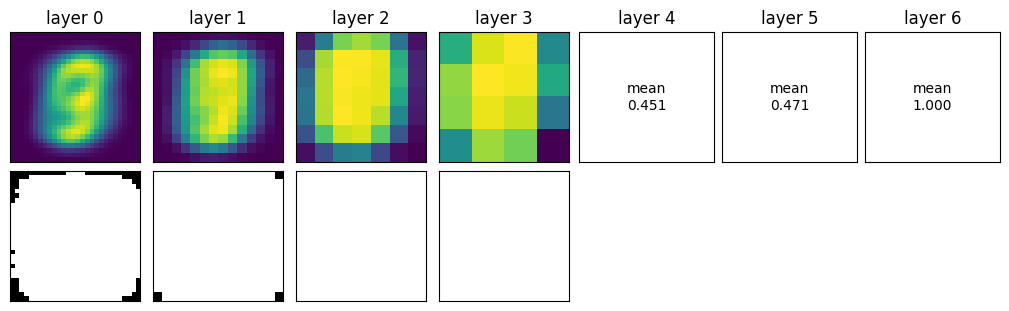

In [58]:
# Before any training
model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
model_stats, layer_stats, layer_spatial_stats = toolkit.measure_unit_activity(model, dataset, include_spatial_activity=True, verbose=1)
print(f"model_stats: {model_stats}")
print(f"layer_stats: {layer_stats}")
print(f"layer_spatial_stats: x{[stat.shape for stat in layer_spatial_stats]}")

toolkit.plot_spatial_stats(layer_spatial_stats)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.8566 - loss: 0.4869
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.9764 - loss: 0.0796
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9854 - loss: 0.0495
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.9899 - loss: 0.0348
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 44ms/step - accuracy: 0.9917 - loss: 0.0280
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.9938 - loss: 0.0208
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.9945 - loss: 0.0166
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 45ms/step - accuracy: 0.9960 - loss: 0.0130
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 44ms/step - accuracy: 0.9961 - loss: 0.0119
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.9957 - loss: 0.0112
Total training time: 543.17 secs


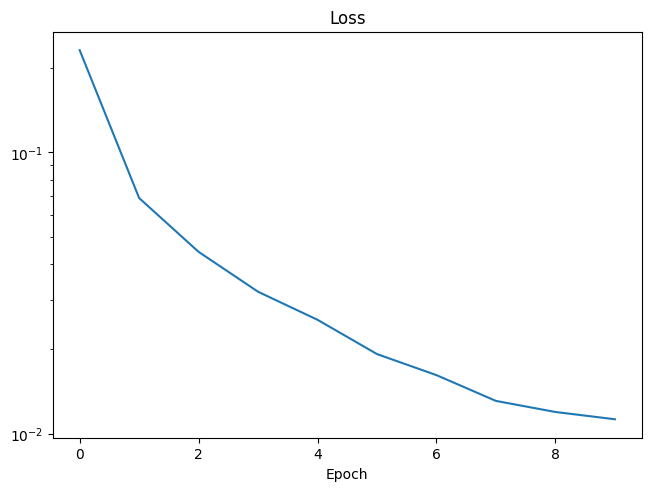

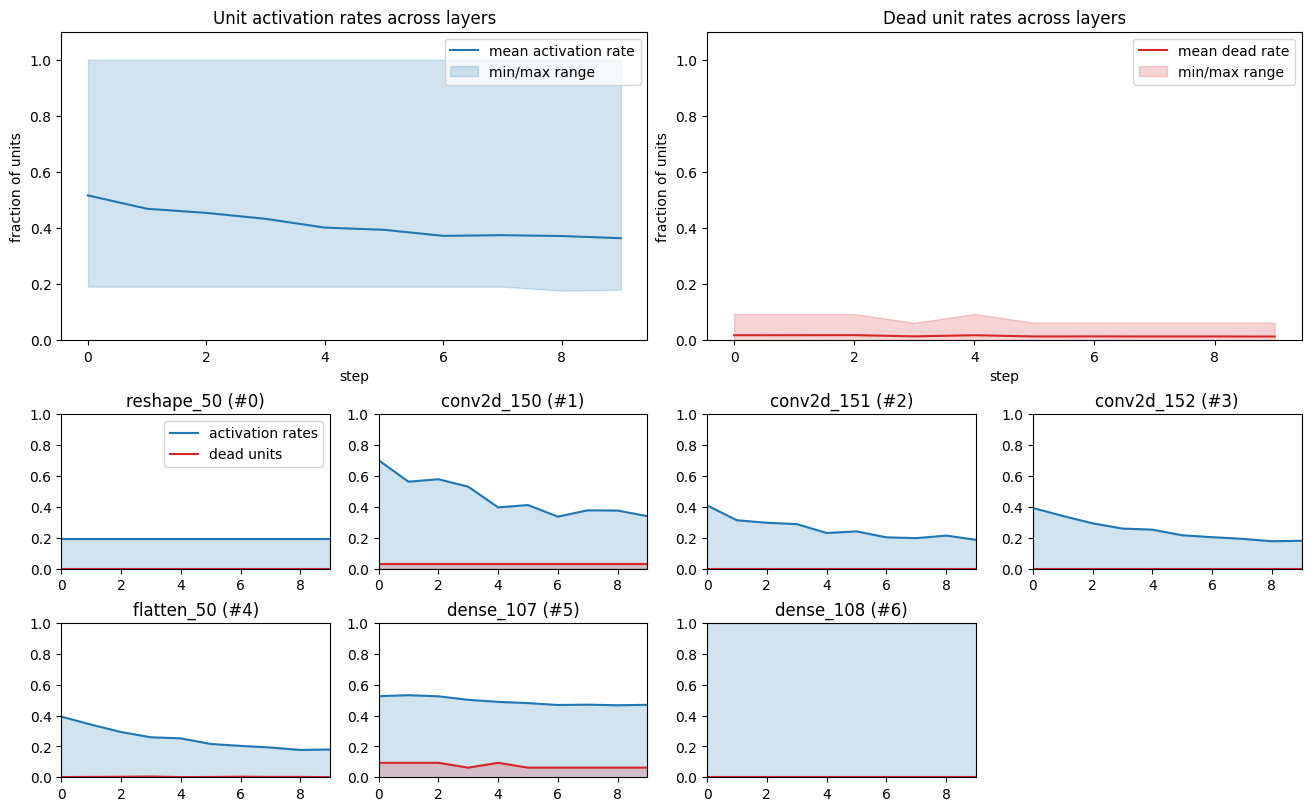

In [61]:
# Model training
start = tf.timestamp()
model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
activity = toolkit.ActivityRateCallback(dataset, interval=1)
history = model.fit(dataset, epochs=10, callbacks=[activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

activity.plot()

100%|██████████| 938/938 [00:15<00:00, 61.51it/s]


model_stats: {'min_dead_rate': 0.0, 'max_dead_rate': 0.0625, 'mean_dead_rate': 0.013532366071428572, 'min_activation_rate': 0.18012425, 'max_activation_rate': 1.0, 'mean_activation_rate': 0.3638618}
layer_stats: [{'dead_rate': 0.0, 'activation_rate': 0.19119719}, {'dead_rate': 0.03125, 'activation_rate': 0.33962214}, {'dead_rate': 0.0, 'activation_rate': 0.18631692}, {'dead_rate': 0.0, 'activation_rate': 0.18012427}, {'dead_rate': 0.0009765625, 'activation_rate': 0.18012425}, {'dead_rate': 0.0625, 'activation_rate': 0.46964794}, {'dead_rate': 0.0, 'activation_rate': 1.0}]
layer_spatial_stats: x[TensorShape([28, 28]), TensorShape([14, 14]), TensorShape([7, 7]), TensorShape([4, 4]), TensorShape([]), TensorShape([]), TensorShape([])]


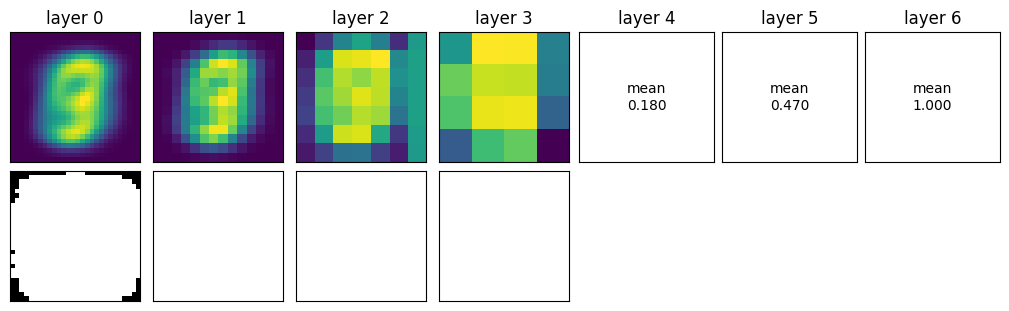

In [62]:
# and show spatial stats at end
model_stats, layer_stats, layer_spatial_stats = toolkit.measure_unit_activity(model, dataset, include_spatial_activity=True, verbose=1)
print(f"model_stats: {model_stats}")
print(f"layer_stats: {layer_stats}")
print(f"layer_spatial_stats: x{[stat.shape for stat in layer_spatial_stats]}")

toolkit.plot_spatial_stats(layer_spatial_stats)

In [332]:
model.summary()

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_13 (Reshape)                 │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_37 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_428 (Dense)                    │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_429 (Dense)                    │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 475,712 (1.81 MB)

 Trainable params: 158,570 (619.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 317,142 (1.21 MB)

## Appendix: Collecting stats against static model
First, let's just make sure we can cope with some variation in how data is provided.

In [30]:
def do_stuff(model, x, batch_size=None, steps_per_epoch=None):
  """
  Args:
    model: The model to evaluate.
    x: Input data or dataset
    batch_size: Batch size (at least one of this or steps_per_epoch required if x or dataset not already batched).
    steps_per_epoch: Steps per epoch, required if dataset is unbatched.
  """

  # handle variations in how data is supplied
  if isinstance(x, tf.data.Dataset):
    dataset = x
    # ensure dataset has been batched
    if not hasattr(dataset, "_batch_size"):
      if batch_size is None and steps_per_epoch is not None:
        batch_size = int(math.ceil(dataset.cardinality().numpy() / steps_per_epoch))
      if batch_size is not None:
        dataset = dataset.batch(batch_size)
      else:
        raise ValueError("dataset not batched and unable to infer batch size.")
  else:
    if batch_size is None and steps_per_epoch is not None:
      batch_size = int(math.ceil(len(x) / steps_per_epoch))
    if batch_size is None:
      raise ValueError("one of batch_size or steps_per_epoch must be provided when x list/array given.")
    y = tf.zeros((len(x),))  # fake y values
    dataset = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

  # extract individual layer activations
  monitoring_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])
  inputs, outputs = next(iter(dataset))
  print(f"inputs: {inputs.shape}")
  layer_outputs = monitoring_model(inputs)
  print(f"layer_outputs: {len(layer_outputs)}")

# with raw x
do_stuff(model, train_X, batch_size=32)

# with un-batched dataset
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
do_stuff(model, dataset, batch_size=32)

# with batched dataset
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(32)
do_stuff(model, dataset)

inputs: (32, 2)
layer_outputs: 7
inputs: (32, 2)
layer_outputs: 7
inputs: (32, 2)
layer_outputs: 7


## Appendix: Optimising speed
This took a _lot_ of experiments. The first problem is that the model returns a tuple of outputs and I need to iterate over that tuple. The second problem is that I need to accumulate results over each of the batches - this requires initailising something and updating it each batch. The third problem is that I'm dealing with tuples of different shapes and sizes. It's fairly easy to cope with two out of these three problems, but not to do all three together.

After many experiments, I found the only working solution is to initialise tf.Variables() outside of the `@tf.function` and pass them in. That works even if they're in a list that needs to be iterated over.

Through that, I was able to optimise iteration over the 938 batches of the MNIST dataset from about 40s to about 12.5s. Quite a sizeable and worthwhile achivement.

For the sake of later reference, all the many attemps are retained in the section below.

**A brief note on @tf.function() vs programmatic auto-graphic and retracing issues**

I'm still getting lots of retracing warnings.
This could potentially be resolved by programmatically auto-graphing as follows:
```
compute_stats_fn = tf.function(_compute_stats, reduce_retracing=True)
```

However, there's some extra considerations to consider:
* It appears that manual use of tf.function() _does not_ cache the result. So if it's calling that repeatedly then it's only going to slow things down, and I'll have to find a way to cache the auto-graph result myself. That's a little tricky with the way that I've separated concerns between the training Callback and the `measure_unit_activity()` method.

100%|██████████| 938/938 [00:15<00:00, 59.63it/s]


Total measurement time: 15.80 secs = 16.839702500463293ms/it
model_stats: {'min_dead_rate': 0.0, 'max_dead_rate': 0.0, 'mean_dead_rate': 0.0, 'min_activation_rate': 0.15245023, 'max_activation_rate': 1.0, 'mean_activation_rate': 0.4300407}
layer_stats: [{'dead_rate': 0.0, 'activation_rate': 0.19119719}, {'dead_rate': 0.0, 'activation_rate': 0.15245023}, {'dead_rate': 0.0, 'activation_rate': 0.29580045}, {'dead_rate': 0.0, 'activation_rate': 0.41319674}, {'dead_rate': 0.0, 'activation_rate': 0.41319674}, {'dead_rate': 0.0, 'activation_rate': 0.5444435}, {'dead_rate': 0.0, 'activation_rate': 1.0}]
layer_spatial_stats: x[TensorShape([28, 28]), TensorShape([14, 14]), TensorShape([7, 7]), TensorShape([4, 4]), TensorShape([]), TensorShape([]), TensorShape([])]


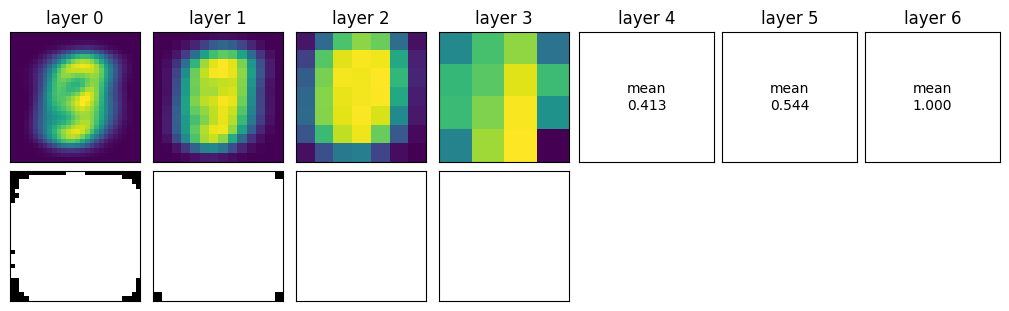

In [56]:
# Baseline:
#   - about 40.64secs for full 938 batches = 43ms/it (reported around 23.09it/s)
# Result after optimising with @tf.function:
#   - 10 to 15s for full 938 batches = 13ms/it
#   - same range of times with with/without progress bar, but tends to be on the upper end of the range
model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)

start = tf.timestamp()
model_stats, layer_stats, layer_spatial_stats = toolkit.measure_unit_activity(model, dataset, include_spatial_activity=True, verbose=1)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs = {duration.numpy()/938 * 1000.0}ms/it")

print(f"model_stats: {model_stats}")
print(f"layer_stats: {layer_stats}")
print(f"layer_spatial_stats: x{[stat.shape for stat in layer_spatial_stats]}")

toolkit.plot_spatial_stats(layer_spatial_stats)

## Appendix: Experimenting with options for auto-graphing the internals
Lots and lots of raw experiments.

See the notes above for a summary of the outcomes.

In [342]:
@tf.function
def get_some_stats():
  print(f"called once")
  a = tf.random.normal((100,100))
  return {
      'mean': tf.reduce_mean(a),
      'min': tf.reduce_min(a),
      'max': tf.reduce_max(a)
  }

tf.random.set_seed(1)
for i in range(10):
  res = get_some_stats()
res

called once


{'mean': <tf.Tensor: shape=(), dtype=float32, numpy=7.9117584e-05>,
 'min': <tf.Tensor: shape=(), dtype=float32, numpy=-4.0065737>,
 'max': <tf.Tensor: shape=(), dtype=float32, numpy=3.9874067>}

In [6]:
model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64).take(50)
monitoring_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])

In [9]:
monitoring_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,570 (619.41 KB)

 Trainable params: 158,570 (619.41 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# This proves that doing the optimisation is worth it:
#  without tf.function: ~30sc
#  with    tf.function: ~12sec
@tf.function
def compute_sums(monitoring_model, dataset):
    num_batches = 0
    num_layers = 0.0
    for inputs, _ in dataset:
        num_batches += 1
        layer_outputs = monitoring_model(inputs=inputs, training=False)
        for l_idx, layer_output in enumerate(layer_outputs):
            active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.float32)
            num_layers += tf.reduce_mean(active_outputs)

    return num_batches, num_layers

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
start = tf.timestamp()
res = compute_sums(monitoring_model, dataset)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
res

Total measurement time: 11.74 secs


(<tf.Tensor: shape=(), dtype=int32, numpy=938>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2687.5054>)

In [17]:
# No benefit in moving out just the model computations.
@tf.function
def compute_outputs(model, inputs):
  layer_outputs = model(inputs=inputs, training=False)
  #if isinstance(layer_outputs, tf.Tensor):
  #  layer_outputs = tf.unstack(layer_outputs)
  #print(f"layer_outputs: {type(layer_outputs)}, shape: {layer_outputs.shape}")
  active_outputs = [tf.cast(tf.not_equal(layer_output, 0.0), tf.float32) for layer_output in layer_outputs]
  return active_outputs

def compute_sums(monitoring_model, dataset):
    num_batches = 0
    num_layers = 0.0
    for inputs, _ in dataset:
        num_batches += 1
        active_outputs = compute_outputs(monitoring_model, inputs)
        for l_idx, active_output in enumerate(active_outputs):
            num_layers += tf.reduce_mean(active_output)

    return num_batches, num_layers

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
start = tf.timestamp()
res = compute_sums(monitoring_model, dataset)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
res

Total measurement time: 16.09 secs


(938, <tf.Tensor: shape=(), dtype=float32, numpy=2817.7896>)

In [8]:
# trying using t.fwhile etc.
@tf.function
def process_model_outputs(model, inputs):
    # Call the model to get a Python tuple of outputs
    outputs = model.call(inputs)

    # Initialize loop variables
    num_items = tf.constant(len(outputs))  # Get the tuple length
    idx = tf.constant(0)  # Start index
    results = tf.TensorArray(dtype=tf.float32, size=num_items, dynamic_size=True)

    # Define the loop condition
    def condition(index, _):
        return index < num_items

    # Define the loop body
    def body(index, results_array):
        item = outputs[index]  # Get the current item
        # Example operation: Apply a rank-independent function
        result = tf.reduce_sum(item)  # Replace with your desired function
        results_array = results_array.write(index, result)  # Write the result
        return index + 1, results_array

    # Run the loop
    _, results = tf.while_loop(
        cond=condition,
        body=body,
        loop_vars=[idx, results],
        shape_invariants=[idx.get_shape(), tf.TensorShape(None)],
    )

    # Convert TensorArray to a Python list of tensors
    results_list = [results.read(i) for i in range(num_items)]

    return results_list

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
start = tf.timestamp()
res = process_model_outputs(monitoring_model, dataset)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
res

TypeError: in user code:

    File "<ipython-input-8-613176ebefd7>", line 5, in process_model_outputs  *
        outputs = model.call(inputs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 167, in call  **
        inputs = self._standardize_inputs(inputs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 258, in _standardize_inputs
        flat_inputs = self._convert_inputs_to_tensors(flat_inputs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 218, in _convert_inputs_to_tensors
        ops.convert_to_tensor(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 822, in convert_to_tensor
        return backend.convert_to_tensor(x, dtype=dtype, sparse=sparse)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/core.py", line 125, in convert_to_tensor
        return tf.convert_to_tensor(x, dtype=dtype)

    TypeError: Expected float32, but got <_VariantDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))> of type '_VariantDataset'.


In [19]:
# Trying to use tf.Variable instead
# - first basic outline
@tf.function
def compute_sums(monitoring_model, dataset, var1):
    num_batches = 0
    num_layers = 0.0
    for inputs, _ in dataset:
        num_batches += 1
        layer_outputs = monitoring_model(inputs=inputs, training=False)
        for l_idx, layer_output in enumerate(layer_outputs):
            active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.float32)
            var1.assign_add(tf.reduce_mean(active_outputs))

    return num_batches, num_layers, var1

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64).take(50)
start = tf.timestamp()
var1 = tf.Variable(0.0, dtype=tf.float32)
res = compute_sums(monitoring_model, dataset, var1)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
res


Total measurement time: 1.27 secs


(<tf.Tensor: shape=(), dtype=int32, numpy=50>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=143.39041>)

In [40]:
# - working with list and basic values types
@tf.function
def compute_sums(monitoring_model, dataset, layer_vars):
    num_batches = 0
    num_layers = 0.0
    for inputs, _ in dataset:
        num_batches += 1
        layer_outputs = monitoring_model(inputs=inputs, training=False)
        for l_idx, layer_output in enumerate(layer_outputs):
            active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.float32)
            layer_vars[l_idx].assign_add(tf.reduce_mean(active_outputs))

    return num_batches, num_layers, layer_vars

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64).take(1000)

layer_vars = [tf.Variable(0.0, dtype=tf.float32) for _ in range(len(monitoring_model.outputs))]

start = tf.timestamp()
res = compute_sums(monitoring_model, dataset, layer_vars)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
res

Total measurement time: 9.67 secs


(<tf.Tensor: shape=(), dtype=int32, numpy=938>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 [<tf.Tensor: shape=(), dtype=float32, numpy=179.34296>,
  <tf.Tensor: shape=(), dtype=float32, numpy=174.97084>,
  <tf.Tensor: shape=(), dtype=float32, numpy=237.53914>,
  <tf.Tensor: shape=(), dtype=float32, numpy=400.9486>,
  <tf.Tensor: shape=(), dtype=float32, numpy=400.9486>,
  <tf.Tensor: shape=(), dtype=float32, numpy=355.75635>,
  <tf.Tensor: shape=(), dtype=float32, numpy=938.0>])

In [39]:
# - working with list of full tensors
@tf.function
def compute_sums(monitoring_model, dataset, layer_vars):
    num_batches = 0
    num_layers = 0.0
    for inputs, _ in dataset:
        num_batches += 1
        layer_outputs = monitoring_model(inputs=inputs, training=False)
        for l_idx, layer_output in enumerate(layer_outputs):
            active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.float32)
            #active_counts_by_channel = tf.ones(46, dtype=tf.float32)
            #num_layers += tf.reduce_mean(active_counts_by_channel)
            #var1.assign_add(tf.ones((46,)))
            layer_vars[l_idx].assign_add(active_outputs)
            #var1.assign_add(tf.reduce_mean(active_outputs))
            #var2.assign_add(tf.reduce_sum(active_outputs))

    return num_batches, num_layers, layer_vars

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64).take(50)


layer_vars = [tf.Variable(tf.zeros(shape = (64,) + output.shape[1:]), dtype=tf.float32) for output in monitoring_model.outputs]
print(f"layer_vars: {[var.shape for var in layer_vars]}")

start = tf.timestamp()
res = compute_sums(monitoring_model, dataset, layer_vars)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
print(f"res: {res[0:2]}, vars: {[var.shape for var in res[2]]}")

layer_vars: [TensorShape([64, 28, 28, 1]), TensorShape([64, 14, 14, 32]), TensorShape([64, 7, 7, 64]), TensorShape([64, 4, 4, 128]), TensorShape([64, 2048]), TensorShape([64, 32]), TensorShape([64, 10])]
Total measurement time: 1.30 secs
res: (<tf.Tensor: shape=(), dtype=int32, numpy=50>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>), vars: [TensorShape([64, 28, 28, 1]), TensorShape([64, 14, 14, 32]), TensorShape([64, 7, 7, 64]), TensorShape([64, 4, 4, 128]), TensorShape([64, 2048]), TensorShape([64, 32]), TensorShape([64, 10])]


In [45]:
# - Successful!!!!!
# Execution time on 1000 dataset: ~10s
@tf.function
def compute_sums(monitoring_model, dataset, layer_vars):
    num_batches = 0
    num_layers = 0.0
    for inputs, _ in dataset:
        num_batches += 1
        layer_outputs = monitoring_model(inputs=inputs, training=False)
        for l_idx, layer_output in enumerate(layer_outputs):
            active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.float32)
            active_counts_by_channel = tf.reduce_mean(active_outputs, axis=tf.range(tf.rank(active_outputs) - 1))
            layer_vars[l_idx].assign_add(active_counts_by_channel)

    return num_batches, num_layers, layer_vars

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64).take(1000)


layer_vars = [tf.Variable(tf.zeros(shape = output.shape[-1]), dtype=tf.float32) for output in monitoring_model.outputs]
print(f"layer_vars: {[var.shape for var in layer_vars]}")

start = tf.timestamp()
res = compute_sums(monitoring_model, dataset, layer_vars)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
print(f"res: {res[0:2]}")
for l_idx, var in enumerate(layer_vars):
  print(f"[{l_idx}]: {var.shape} -> {tf.reduce_mean(var).numpy()}")

layer_vars: [TensorShape([1]), TensorShape([32]), TensorShape([64]), TensorShape([128]), TensorShape([2048]), TensorShape([32]), TensorShape([10])]
Total measurement time: 10.36 secs
res: (<tf.Tensor: shape=(), dtype=int32, numpy=938>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)
[0]: (1,) -> 179.34295654296875
[1]: (32,) -> 174.97067260742188
[2]: (64,) -> 237.5390167236328
[3]: (128,) -> 400.9483947753906
[4]: (2048,) -> 400.9483947753906
[5]: (32,) -> 355.75634765625
[6]: (10,) -> 938.0


In [51]:
# experimenting with programmatic auto-graph control
# - 30s vs 15s
def compute_sums(monitoring_model, dataset, layer_vars):
    num_batches = 0
    num_layers = 0.0
    for inputs, _ in dataset:
        num_batches += 5
        layer_outputs = monitoring_model(inputs=inputs, training=False)
        for l_idx, layer_output in enumerate(layer_outputs):
            active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.float32)
            active_counts_by_channel = tf.reduce_mean(active_outputs, axis=tf.range(tf.rank(active_outputs) - 1))
            layer_vars[l_idx].assign_add(active_counts_by_channel)

    return num_batches, num_layers, layer_vars

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64).take(1000)


layer_vars = [tf.Variable(tf.zeros(shape = output.shape[-1]), dtype=tf.float32) for output in monitoring_model.outputs]
print(f"layer_vars: {[var.shape for var in layer_vars]}")

start = tf.timestamp()
compute_sums_fn = tf.function(compute_sums, reduce_retracing=True)
#compute_sums_fn = compute_sums
duration = tf.timestamp() - start
print(f"Auto-graphing time: {duration.numpy():.2f} secs")

start = tf.timestamp()
res = compute_sums_fn(monitoring_model, dataset, layer_vars)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
print(f"res: {res[0:2]}")
for l_idx, var in enumerate(layer_vars):
  print(f"[{l_idx}]: {var.shape} -> {tf.reduce_mean(var).numpy()}")

layer_vars: [TensorShape([1]), TensorShape([32]), TensorShape([64]), TensorShape([128]), TensorShape([2048]), TensorShape([32]), TensorShape([10])]
Auto-graphing time: 0.00 secs
Total measurement time: 11.34 secs
res: (<tf.Tensor: shape=(), dtype=int32, numpy=4690>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)
[0]: (1,) -> 179.34295654296875
[1]: (32,) -> 174.97067260742188
[2]: (64,) -> 237.5390167236328
[3]: (128,) -> 400.9483947753906
[4]: (2048,) -> 400.9483947753906
[5]: (32,) -> 355.75634765625
[6]: (10,) -> 938.0


In [25]:
# Applying tf.variable approach but using normal constants -- doesn't work
@tf.function
def compute_sums(monitoring_model, dataset, layer_vars):
    num_batches = 0
    num_layers = 0.0
    for inputs, _ in dataset:
        num_batches += 1
        layer_outputs = monitoring_model(inputs=inputs, training=False)
        for l_idx, layer_output in enumerate(layer_outputs):
            active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.float32)
            layer_vars[l_idx] = layer_vars[l_idx] + tf.ones(46, dtype=tf.float32)

    return num_batches, num_layers, layer_vars

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64).take(1000)

layer_vars = [tf.zeros((46,), dtype=tf.float32) for _ in range(len(monitoring_model.outputs))]

start = tf.timestamp()
res = compute_sums(monitoring_model, dataset, layer_vars)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
res

InaccessibleTensorError: <tf.Tensor 'add_1:0' shape=(46,) dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.

<tf.Tensor 'add_1:0' shape=(46,) dtype=float32> was defined here:
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    File "<ipython-input-25-d7c9391fd542>", line 25, in <cell line: 25>
    File "<ipython-input-25-d7c9391fd542>", line 6, in compute_sums
    File "<ipython-input-25-d7c9391fd542>", line 9, in compute_sums
    File "<ipython-input-25-d7c9391fd542>", line 14, in compute_sums

The tensor <tf.Tensor 'add_1:0' shape=(46,) dtype=float32> cannot be accessed from FuncGraph(name=compute_sums, id=140052390620992), because it was defined in FuncGraph(name=Dataset_scan_scan_body, id=140052390613056), which is out of scope.

In [15]:
@tf.function
def compute_sums(monitoring_model, dataset):
    tmp = tf.zeros((46,))

    num_batches = 0
    num_layers = 0.0
    for inputs, _ in dataset:
        num_batches += 1
        layer_outputs = monitoring_model(inputs=inputs, training=False)
        for l_idx, layer_output in enumerate(layer_outputs):
            active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.float32)
            active_counts_by_channel = tf.ones(46, dtype=tf.float32)
            num_layers += tf.reduce_mean(active_counts_by_channel)
            tmp += tf.ones((46,))

    return num_batches, num_layers, tf.reduce_mean(tmp)

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
start = tf.timestamp()
res = compute_sums(monitoring_model, dataset)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
res


Total measurement time: 1.02 secs


(<tf.Tensor: shape=(), dtype=int32, numpy=938>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6566.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6566.0>)

In [16]:
# Million other attempts....
@tf.function
def compute_sums(monitoring_model, dataset):
    tmp = tf.zeros((64,))

    num_batches = 0
    print("first call")
    for inputs, _ in dataset:
        num_batches += 1
        layer_outputs = monitoring_model(inputs=inputs, training=False)
        for l_idx, layer_output in enumerate(layer_outputs):
            active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.float32)
            tmp += tf.reduce_mean(active_outputs, axis=tf.range(1, tf.rank(active_outputs)))

    return num_batches, tf.reduce_sum(tmp)

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64).take(50)
start = tf.timestamp()
res = compute_sums(monitoring_model, dataset)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
res


first call
Total measurement time: 1.67 secs


(<tf.Tensor: shape=(), dtype=int32, numpy=50>,
 <tf.Tensor: shape=(), dtype=float32, numpy=9624.519>)

In [417]:
@tf.function
def compute_sums(monitoring_model, dataset):
    tmp1 = tf.zeros((64,))
    tmp2 = [tf.ones((64,))] # * len(monitoring_model.outputs)

    foo = None
    num_batches = 0
    print("first call")
    for inputs, _ in dataset:
        num_batches += 1
        layer_outputs = monitoring_model(inputs=inputs, training=False)
        for l_idx, layer_output in enumerate(layer_outputs):
            active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.float32)
            #tmp += tf.ones((46,))
            tmp1 += tf.reduce_mean(active_outputs, axis=tf.range(1, tf.rank(active_outputs)))
            #tmp2 = [tf.reduce_mean(active_outputs, axis=tf.range(1, tf.rank(active_outputs)))]
            tmp2 = [tf.reduce_mean(active_outputs, axis=0)]
            print(f"tmp2-item: {tf.reduce_mean(active_outputs, axis=0).shape}")

    return num_batches, tf.reduce_sum(tmp2)

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64).take(50)
start = tf.timestamp()
res = compute_sums(monitoring_model, dataset)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
res

first call
tmp2-item: (28, 28, 1)
tmp2-item: (14, 14, 32)
tmp2-item: (7, 7, 64)
tmp2-item: (4, 4, 128)
tmp2-item: (2048,)
tmp2-item: (32,)
tmp2-item: (10,)


TypeError: in user code:

    File "<ipython-input-417-8c4e4b88ab2b>", line 9, in compute_sums  *
        for inputs, _ in dataset:

    TypeError: 'tmp2' does not have the same nested structure after one iteration.
    
    The two structures don't have the same nested structure.
    
    First structure: type=list str=[<tf.Tensor 'ones:0' shape=(64,) dtype=float32>]
    
    Second structure: type=SymbolicTensor str=Tensor("args_1:0", shape=(1, 64), dtype=float32)
    
    More specifically: Substructure "type=list str=[<tf.Tensor 'ones:0' shape=(64,) dtype=float32>]" is a sequence, while substructure "type=SymbolicTensor str=Tensor("args_1:0", shape=(1, 64), dtype=float32)" is not
    Entire first structure:
    [.]
    Entire second structure:
    .


In [25]:
@tf.function
def compute_sums(monitoring_model, dataset):
    tmp1 = tf.zeros((64,))
    tmp2 = [tf.ones((64,))] # * len(monitoring_model.outputs)

    sample_inputs, _ = next(iter(dataset.take(1)))
    initial_outputs = monitoring_model(sample_inputs)
    #tmp3 = [tf.zeros_like(output, dtype=tf.float32) for output in initial_outputs]
    tmp3 = [out for out in initial_outputs]

    foo = None
    num_batches = 0
    print("first call")
    for inputs, _ in dataset:
        num_batches += 1
        layer_outputs = monitoring_model(inputs=inputs, training=False)
        #for l_idx, layer_output in enumerate(layer_outputs):
        #    active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.float32)
        #    #tmp += tf.ones((46,))
        #    tmp1 += tf.reduce_mean(active_outputs, axis=tf.range(1, tf.rank(active_outputs)))
        #    #tmp2 = [tf.reduce_mean(active_outputs, axis=tf.range(1, tf.rank(active_outputs)))]
        #    #tmp2 = [tf.reduce_mean(active_outputs, axis=0)]
        #    #print(f"tmp2-item: {tf.reduce_mean(active_outputs, axis=0).shape}")
        tmp3 = [out for out in layer_outputs]

    return num_batches, len(tmp3)

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64).take(50)
start = tf.timestamp()
res = compute_sums(monitoring_model, dataset)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
res

first call


ValueError: in user code:

    File "<ipython-input-25-dfad428b384f>", line 14, in compute_sums  *
        for inputs, _ in dataset:

    ValueError: Dimension 1 in both shapes must be equal, but are 32 and 10. Shapes are [?,32] and [?,10].
    	From merging shape 5 with other shapes. for '{{node normalize_element/component_1}} = Pack[N=7, T=DT_FLOAT, axis=0](functional_1_1/reshape_1/Reshape, functional_1_1/conv2d_1/Relu, functional_1_1/conv2d_1_2/Relu, functional_1_1/conv2d_2_1/Relu, functional_1_1/flatten_1/Reshape, functional_1_1/dense_1/Relu, functional_1_1/dense_1_2/Softmax)' with input shapes: [?,28,28,1], [?,14,14,32], [?,7,7,64], [?,4,4,128], [?,2048], [?,32], [?,10].


In [382]:
def compute_means_step(model, inputs):
    outputs = model(inputs)
    values_by_layer = [tf.reduce_mean(output) for output in outputs]
    return

@tf.function
def compute_sums(model, dataset):
    # Initialize values_by_layer dynamically based on the number of model layers
    #sample_inputs, _ = next(iter(dataset))
    #initial_outputs = model(sample_inputs)
    #num_layers = len(initial_outputs)
    #values_by_layer = [tf.zeros((1,)) for output in initial_outputs]
    values_by_layer = [tf.zeros((1,)) for _ in model.outputs]
    #values_by_layer = []
    initialized = False

    for inputs, _ in dataset:
        #layer_outputs = compute_means_step(model, inputs)
        outputs = model(inputs)
        #layer_outputs = [tf.reduce_mean(output) for output in outputs]
        #values_by_layer = [values_by_layer[l_idx] + tf.reduce_mean(output,axis=-1) for l_idx, output in enumerate(outputs)]
        if not initialized:
          values_by_layer = [tf.reduce_mean(output) for l_idx, output in enumerate(outputs)]
          initialized = True
        else:
          values_by_layer = [values_by_layer[l_idx] + tf.reduce_mean(output) for l_idx, output in enumerate(outputs)]


    return values_by_layer
start = tf.timestamp()
res = compute_sums(monitoring_model, dataset)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
res


TypeError: in user code:

    File "<ipython-input-382-0e514bbd8a8d>", line 17, in compute_sums  *
        for inputs, _ in dataset:

    TypeError: 'values_by_layer' does not have the same nested structure after one iteration.
    
    The two structures don't have the same nested structure.
    
    First structure: type=list str=[<tf.Tensor 'zeros:0' shape=(1,) dtype=float32>, <tf.Tensor 'zeros_1:0' shape=(1,) dtype=float32>, <tf.Tensor 'zeros_2:0' shape=(1,) dtype=float32>, <tf.Tensor 'zeros_3:0' shape=(1,) dtype=float32>, <tf.Tensor 'zeros_4:0' shape=(1,) dtype=float32>, <tf.Tensor 'zeros_5:0' shape=(1,) dtype=float32>, <tf.Tensor 'zeros_6:0' shape=(1,) dtype=float32>]
    
    Second structure: type=SymbolicTensor str=Tensor("args_0:0", shape=(7, 1), dtype=float32)
    
    More specifically: Substructure "type=list str=[<tf.Tensor 'zeros:0' shape=(1,) dtype=float32>, <tf.Tensor 'zeros_1:0' shape=(1,) dtype=float32>, <tf.Tensor 'zeros_2:0' shape=(1,) dtype=float32>, <tf.Tensor 'zeros_3:0' shape=(1,) dtype=float32>, <tf.Tensor 'zeros_4:0' shape=(1,) dtype=float32>, <tf.Tensor 'zeros_5:0' shape=(1,) dtype=float32>, <tf.Tensor 'zeros_6:0' shape=(1,) dtype=float32>]" is a sequence, while substructure "type=SymbolicTensor str=Tensor("args_0:0", shape=(7, 1), dtype=float32)" is not
    Entire first structure:
    [., ., ., ., ., ., .]
    Entire second structure:
    .


In [370]:
@tf.function
def compute_sums(monitoring_model, dataset):
    channel_sizes = [shape[-1] for shape in monitoring_model.output_shape]
    spatial_dims = [shape[1:-1] if len(shape) > 2 else (1,) for shape in monitoring_model.output_shape]
    layer_channel_activity_sums = [tf.zeros(46, dtype=tf.float32) for size in channel_sizes]  # by channel

    active_counts_by_channel1 = tf.ones(46, dtype=tf.float32)
    layer_channel_activity_sums[0] += active_counts_by_channel1

    tmp = tf.zeros(46, dtype=tf.float32)
    tmps = [tmp]

    num_batches = 0
    num_layers = 0.0
    for inputs, _ in dataset:
        num_batches += 1
        layer_outputs = monitoring_model(inputs=inputs, training=False)
        for l_idx, layer_output in enumerate(layer_outputs):
            active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.float32)
            #active_counts_by_channel = tf.reduce_mean(active_outputs, axis=tf.range(tf.rank(active_outputs) - 1))
            active_counts_by_channel = tf.ones(46, dtype=tf.float32)
            num_layers += tf.reduce_mean(active_counts_by_channel)
            #layer_channel_activity_sums[l_idx] += active_counts_by_channel
            tmp[0] += tf.ones(46, dtype=tf.float32)

    channel_sizes = num_layers
    return layer_channel_activity_sums, num_batches, spatial_dims, channel_sizes



start = tf.timestamp()
res = compute_sums(monitoring_model, dataset)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
res


TypeError: in user code:

    File "<ipython-input-370-bec7fde8a1cf>", line 15, in compute_sums  *
        for inputs, _ in dataset:
    File "/tmp/__autograph_generated_file4wyv70mo.py", line 25, in set_state_1
        (num_batches, num_layers, tmp[0]) = vars_

    TypeError: 'SymbolicTensor' object does not support item assignment


In [364]:
@tf.function
def compute_sums(monitoring_model, dataset):
    channel_sizes = [shape[-1] for shape in monitoring_model.output_shape]
    spatial_dims = [shape[1:-1] if len(shape) > 2 else (1,) for shape in monitoring_model.output_shape]
    layer_channel_activity_sums = [tf.zeros(size, dtype=tf.float32) for size in channel_sizes]  # by channel

    num_batches = 0
    num_layers = 0.0
    for inputs, _ in dataset:
        num_batches += 1
        layer_outputs = monitoring_model(inputs=inputs, training=False)
        for l_idx, layer_output in enumerate(layer_outputs):
            active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.float32)
            active_counts_by_channel = tf.reduce_mean(active_outputs, axis=tf.range(tf.rank(active_outputs) - 1))
            num_layers += tf.reduce_mean(active_counts_by_channel)
            layer_channel_activity_sums[l_idx] = layer_channel_activity_sums[l_idx] + active_counts_by_channel

    channel_sizes = num_layers
    return layer_channel_activity_sums, num_batches, spatial_dims, channel_sizes



start = tf.timestamp()
res = compute_sums(monitoring_model, dataset)
duration = tf.timestamp() - start
print(f"Total measurement time: {duration.numpy():.2f} secs")
res


InaccessibleTensorError: <tf.Tensor 'add_2:0' shape=(1,) dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.

<tf.Tensor 'add_2:0' shape=(1,) dtype=float32> was defined here:
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    File "<ipython-input-364-5581d4cf1ca3>", line 24, in <cell line: 24>
    File "<ipython-input-364-5581d4cf1ca3>", line 9, in compute_sums
    File "<ipython-input-364-5581d4cf1ca3>", line 12, in compute_sums
    File "<ipython-input-364-5581d4cf1ca3>", line 16, in compute_sums

The tensor <tf.Tensor 'add_2:0' shape=(1,) dtype=float32> cannot be accessed from FuncGraph(name=compute_sums, id=132755891036480), because it was defined in FuncGraph(name=Dataset_scan_scan_body, id=132755891038912), which is out of scope.